In [2]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import numpy as np


#REMOVE THE BACKGROUND


In [10]:
import cv2
def decode_segmap(image, source, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  foreground = cv2.imread(source)
# Change the color of foreground image to RGB
# and resize image to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))
# Create a background array to hold white pixels
# with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)
# Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)
# Create a binary mask of the RGB output map using the threshold value 
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
# Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)
# Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255
# Multiply the foreground with the alpha matter
  foreground = cv2.multiply(alpha, foreground)
# Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)
# Add the masked foreground and background
  outImage = cv2.add(foreground, background)
# Return a normalized output image for display
  return outImage/255



In [11]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([#T.Resize(256), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  fin = decode_segmap(om,path)
  plt.imshow(fin); plt.axis('off'); plt.show()

In [ ]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [ ]:
%cp /content/cat.png /content/drive/My\ Drive

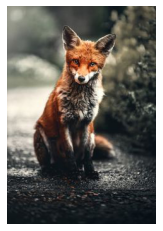

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


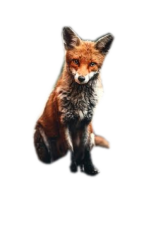

In [12]:
segment(fcn, '/content/drive/My Drive/jackal.png',show_orig=True)

#CHANGE BACKGROUND : USING GREEN SCREEN MATTING WITHOUT GREEN SCREEN

In [16]:
!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png

2020-09-17 14:10:49 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


In [14]:
def decode_segmap(image, source, bgimg, nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)])


  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2) 
  foreground = cv2.imread(source)
# Load the background input image
  background = cv2.imread(bgimg)
# Change the color of foreground &amp;amp;amp;amp;amp; background images to RGB
# and resize images to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))
  background = cv2.resize(background,(r.shape[1],r.shape[0]))
# Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)
# Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
# Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)
# Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255
# Multiply the foreground with the alpha matter
  foreground = cv2.multiply(alpha, foreground)
# Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)
# Add the masked foreground and background
  outImage = cv2.add(foreground, background)
# Return a normalized output image for display
  return outImage/255



In [15]:
def segment(net, path,bgimg, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([#T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om,path,bgimg)
  plt.imshow(rgb); plt.axis('off'); plt.show()

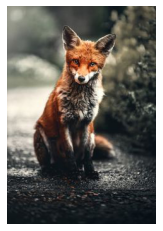

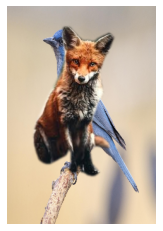

In [18]:
segment(fcn,'/content/drive/My Drive/jackal.png','/content/bird.png')

#  BLUR BACKGROUND

In [19]:
def decode_segmap(image, source,nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
              
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  foreground = cv2.imread(source)
  # Change the color of foreground image to RGB
  # and resize image to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))
# Create a Gaussian blur of kernel size 7 for the background image
  blurredImage = cv2.GaussianBlur(foreground, (7,7), 0)
# Convert uint8 to float
  foreground = foreground.astype(float)
  blurredImage = blurredImage.astype(float)
# Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
# Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)
# Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255
# Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)
# Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, blurredImage)
# Add the masked foreground and background
  outImage = cv2.add(foreground, background)
# Return a normalized output image for display
  return outImage/255

In [20]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([#T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om,path)
  plt.imshow(rgb); plt.axis('off'); plt.show()

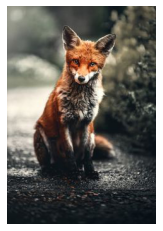

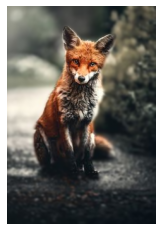

In [21]:
segment(fcn,'/content/drive/My Drive/jackal.png')

# GRAYSCALE BACKGROUND

In [22]:
def decode_segmap(image, source,nc=21):
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255), (255, 255, 255)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  foreground = cv2.imread(source)
  # Change the color of foreground image to RGB
  # and resize image to match shape of R-band in RGB output map
  foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
  foreground = cv2.resize(foreground,(r.shape[1],r.shape[0]))
  # Create a background image by copying foreground and converting into grayscale
  background = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)
# convert single channel grayscale image to 3-channel grayscale image
  background = cv2.cvtColor(background, cv2.COLOR_GRAY2RGB)
# Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)
# Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb),0,255, cv2.THRESH_BINARY)
# Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)
# Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255
# Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)
# Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha,background)
# Add the masked foreground and background
  outImage = cv2.add(foreground, background)
# Return a normalized output image for display
  return outImage/255

In [23]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([#T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om,path)
  plt.imshow(rgb); plt.axis('off'); plt.show()

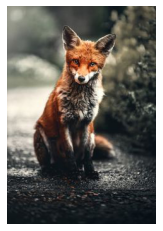

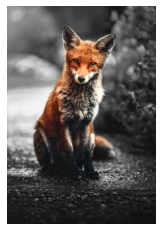

In [24]:
segment(fcn,'/content/drive/My Drive/jackal.png')